In [1]:
import os
import sys
sys.path.insert(0,os.path.join('/project/venv/lib/python3.8/site-packages/'))
sys.path.insert(0,os.path.join('/venv/lib/python3.8/site-packages'))

def ignore_user_installs(username):
    ## avoid using user installs
    user_install_path = '/scratch/' + username + '/python/lib/python3.8/site-packages'
    if user_install_path in sys.path:
        sys.path.remove(user_install_path)

ignore_user_installs("starzew")

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ['HTTP_PROXY'] = 'http://fp.cs.ovgu.de:3210/'
os.environ['HTTPS_PROXY'] = 'http://fp.cs.ovgu.de:3210/'

In [ ]:
import torch
import numpy as np
from matplotlib import pyplot as plt
from transformers import WhisperProcessor, WhisperForConditionalGeneration, AutoFeatureExtractor
import pandas as pd
import dill
import sklearn

from precompute_predictions import att_representation
from compare_representations import cka_layerwise

/usr/local/jupyter/lib/python3.8/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.6) or chardet (5.2.0)/charset_normalizer (2.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "
2025-03-05 14:31:16.928322: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-05 14:31:17.644687: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Using GPU: NVIDIA GeForce RTX 2080 Ti


# Whisper

In [ ]:
# Load model & Feature Extractor
model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-base",attn_implementation="eager")
model_ft = WhisperForConditionalGeneration.from_pretrained("/project/thesis/model/whisper-base-ft/checkpoint-21",attn_implementation="eager")

processor = WhisperProcessor.from_pretrained("openai/whisper-base")
feature_extractor = AutoFeatureExtractor.from_pretrained("openai/whisper-base")
decoder_input_ids = torch.tensor([[1, 1]]) * model.config.decoder_start_token_id

In [4]:
for m in [model, model_ft]:
    m.generation_config.language = "english"
    m.generation_config.task = "transcribe"
    m.generation_config.is_multilingual = False
    m.generation_config.forced_decoder_ids = None

# Dataset

In [5]:
def load_pkl(file_name):
    with open(file_name, 'rb') as inp:
        data = dill.load(inp)
        
    return data

In [6]:
ds_final = load_pkl("datasets/final.pkl")

# Attention Representation

In [ ]:
def permute_atts(atts):
    rng = np.random.default_rng()
    new_atts  = []
    
    for att in atts:
        new_att = np.array(att)
        #print(new_att.shape)
        new_att = rng.permutation(att, axis=-1)
        #print(new_att.shape)
        #new_att = rng.permutation(att, axis=-2)
        #print(new_att.shape)
        new_atts.append(new_att)
    
    return new_atts

def attentions_pt_ft(m_pt, m_ft, severity, n_samples):
    # create random subset of samples
    n_samples = n_samples
    indices = np.random.randint(len(ds_final[severity]),size=n_samples)
    subset = [ds_final[severity][i] for i in indices]

    # extract features
    inputs = feature_extractor(subset, do_normalize=True,sampling_rate=16000,return_tensors="pt")
    inputs = inputs.input_features

    # predict inputs -> attentions
    with torch.no_grad():
        preds_pt = model(inputs, decoder_input_ids=decoder_input_ids, output_attentions=True)
        preds_ft = model_ft(inputs, decoder_input_ids=decoder_input_ids, output_attentions=True)
    attentions_pt = preds_pt.encoder_attentions
    attentions_ft = preds_ft.encoder_attentions
    
    return attentions_pt, attentions_ft

def compare_variants(dims, atts_pt, atts_ft, n_samples):
    variants = ["basic", "resize", "avgpool"]
    #variants = []
    cka_list = []
    cosines_list = []
    cosines_diag_list = []
    
    
    
    for dim in dims: 
        print(dim)
        cka = dict()
        cosines = dict()
        cosines_diag = dict()        
        
        for variant in variants:
            print(variant)
            a_pt = att_representation(atts_pt, variant, dim)
            a_ft = att_representation(atts_ft, variant, dim)
            cka[variant] = np.array(cka_layerwise(a_pt, a_ft))
            #cosines[variant] = cosine_similarity(torch.from_numpy(cka["basic"].reshape(1,6*6)), torch.from_numpy(cka[variant].reshape(1,6*6)))
            cosines[variant] = sklearn.metrics.pairwise.cosine_similarity(cka["basic"].reshape(1,-1),cka[variant].reshape(1,-1))
            #print(cosines[variant].shape)
            #print(np.diagonal(cka["basic"]).shape)
            ##cosines_diag[variant] = sklearn.metrics.pairwise.cosine_similarity(np.diagonal(cka["basic"]).reshape(1,-1), np.diagonal(cka[variant]).reshape(1,-1))
            #cosines_diag[variant] = cosine_similarity(torch.from_numpy(np.diagonal(cka["basic"])), torch.from_numpy(np.diagonal(cka[variant])), dim=0)
        
        print("baseline")
        ## create baseline
        # permute atts
        b_atts_pt = atts_pt
        b_atts_ft = permute_atts(atts_ft)
        # calc datt representation
        b_atts_pt = att_representation(b_atts_pt,"avgpool",dim)
        b_atts_ft = att_representation(b_atts_ft,"avgpool",dim)
        
        # calc baseline cka
        cka["baseline"] = np.array(cka_layerwise(b_atts_pt, b_atts_ft))
        cosines["baseline"] = sklearn.metrics.pairwise.cosine_similarity(cka["basic"].reshape(1,-1),cka["baseline"].reshape(1,-1))
        
        cka_list.append(cka)
        cosines_list.append(cosines)
        cosines_diag_list.append(cosines_diag)
        
    return cka_list, cosines_list, cosines_diag_list

In [8]:
n_samples = 500
sev = "all"
# get attentions for samples
atts_pt_500, atts_ft_500 = attentions_pt_ft(model, model_ft, sev, n_samples)

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.43.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


In [ ]:
dims = [10,15,20,25,30,500,750]
cka_list, cosines_list, cosines_diag_list = compare_variants(dims, atts_pt_500, atts_ft_500, n_samples)

10
basic
resize
avgpool
baseline
15
basic
resize
avgpool
baseline
20
basic
resize
avgpool
baseline
25
basic
resize
avgpool
baseline
30
basic
resize
avgpool
baseline
500
basic
resize
avgpool
baseline
750
basic
resize
avgpool
baseline


In [73]:
df_c = pd.DataFrame(cosines_list)
df_c.index = pd.Index(dims)

In [70]:
df_c

,basic,resize,avgpool,baseline
10,[[1.0]],[[0.9886116539091706]],[[0.9888114273437242]],[[0.9019390751836635]]
15,[[1.0]],[[0.9882468805328968]],[[0.9897888603452714]],[[0.9520867877478254]]


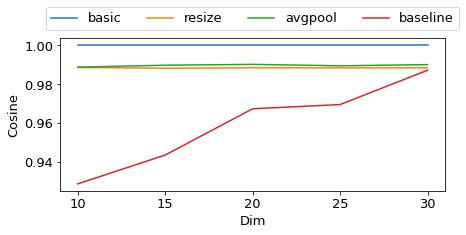

In [ ]:
fs=13
fig = plt.figure()
px = 1/plt.rcParams['figure.dpi']  # pixel in inches
fig.set_figwidth(480*px)
fig.set_figheight(3.5)

for i,df in enumerate([df_c[df_c.index <= 100]]):
    plt.plot(df)
    plt.xlabel("Dim", fontsize=fs)
    plt.ylabel("Cosine", fontsize=fs)
    plt.xticks(range(10,35,5), fontsize=fs)
    plt.yticks(fontsize=fs)
    plt.legend(labels=["basic", "resize", "avgpool", "baseline"], fontsize=fs,loc='upper center', bbox_to_anchor=(0.5, 1.25), ncols=4)

    
plt.tight_layout()
plt.savefig("/figs/datts_exp.pdf", bbox_inches='tight')
plt.show()